1. Instalação de Dependências

In [9]:
# Instalar as dependências necessárias
!pip install tensorflow keras opencv-python-headless scikit-learn matplotlib
!pip install faiss-gpu # Para indexação de vetores

2. Importação das Bibliotecas

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import matplotlib.image as mpimg
from pathlib import Path
import faiss

3. Carregamento e Pré-processamento das Imagens

In [11]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Diretório de base de dados
base_dir = '/content/sample_data/dataset'

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Configurar o gerador de dados de imagem
datagen = ImageDataGenerator(rescale=1./255)

# Carregar imagens de cada classe
classes = ['relógio', 'camiseta', 'bicicleta', 'sapato']
image_data = {}

for cls in classes:
    image_data[cls] = []
    cls_dir = os.path.join(base_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)

        # Verificar se o caminho é um arquivo e não um diretório
        if os.path.isfile(img_path):
            try:
                img = load_and_preprocess_image(img_path)
                image_data[cls].append((img, cls))
            except Exception as e:
                print(f"Erro ao carregar imagem {img_name}: {e}")

4. Extração de Features

In [12]:
# Carregar modelo VGG16 pré-treinado
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=Flatten()(base_model.output))

# Função para extrair características das imagens
def extract_features(img, model):
    features = model.predict(img)
    return features.flatten()

5. Treinamento da Rede com Novas Imagens

In [14]:
from sklearn.model_selection import train_test_split

# Carregar e pré-processar as imagens
base_dir = '/content/sample_data/dataset'

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Configurar o gerador de dados de imagem
datagen = ImageDataGenerator(rescale=1./255)

# Carregar imagens de cada classe
classes = ['relógio', 'camiseta', 'bicicleta', 'sapato']
image_data = {}

for cls in classes:
    image_data[cls] = []
    cls_dir = os.path.join(base_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)

        # Verificar se o caminho é um arquivo e não um diretório
        if os.path.isfile(img_path):
            img = load_and_preprocess_image(img_path)
            if img is not None:  # Somente adicionar imagens carregadas corretamente
                img = img.squeeze()  # Remover a dimensão extra
                image_data[cls].append((img, cls))

# Dividir os dados em conjuntos de treino e teste
X = []
y = []
for cls in classes:
    for img, label in image_data[cls]:
        X.append(img)
        y.append(classes.index(label))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Definir o modelo de rede neural (por exemplo, usando VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step - accuracy: 0.3333 - loss: 2.0023 - val_accuracy: 0.0000e+00 - val_loss: 2.4964
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step - accuracy: 0.3333 - loss: 1.4434 - val_accuracy: 0.0000e+00 - val_loss: 632.8081
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3333 - loss: 375.0595 - val_accuracy: 0.0000e+00 - val_loss: 84.7538
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3333 - loss: 40.4618 - val_accuracy: 0.0000e+00 - val_loss: 3.1582
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3333 - loss: 1.6374 - val_accuracy: 0.0000e+00 - val_loss: 4.0375
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.6667 - loss: 1.5892 - val_accuracy: 0.0000e+00 - val_loss: 1.7249
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step - accuracy: 0.3333 - loss: 1.3069 - val_accuracy: 0.0000e+00 - val_loss: 1.6372
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.3333 - loss: 1.3317 - val_ac

6. Indexação de Vetores com Faiss

In [17]:
import faiss

# Certifique-se de que a função `extract_features` e a variável `base_model` já estão definidas corretamente

# Definir a função de extração de características
def extract_features(img, model):
    img = np.expand_dims(img, axis=0)  # Adiciona uma dimensão extra para a previsão do modelo
    features = model.predict(img)
    return features.flatten()

# Extração de features de todas as imagens e criação do índice Faiss
dimension = base_model.output_shape[-1] * 7 * 7  # Pega a dimensão das saídas do modelo multiplicado pelo tamanho da saída da camada Flatten
index = faiss.IndexFlatL2(dimension)

feature_list = []
path_dict = {}

for cls in classes:
    for img, label in image_data[cls]:
        features = extract_features(img, base_model)
        feature_list.append(features)
        path_dict[len(feature_list) - 1] = (cls, img)

features_array = np.array(feature_list).astype('float32')
index.add(features_array)

print("Indexação concluída com sucesso!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 964ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
Indexação concluída com sucesso!


7. Sistema de Recomendação

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step


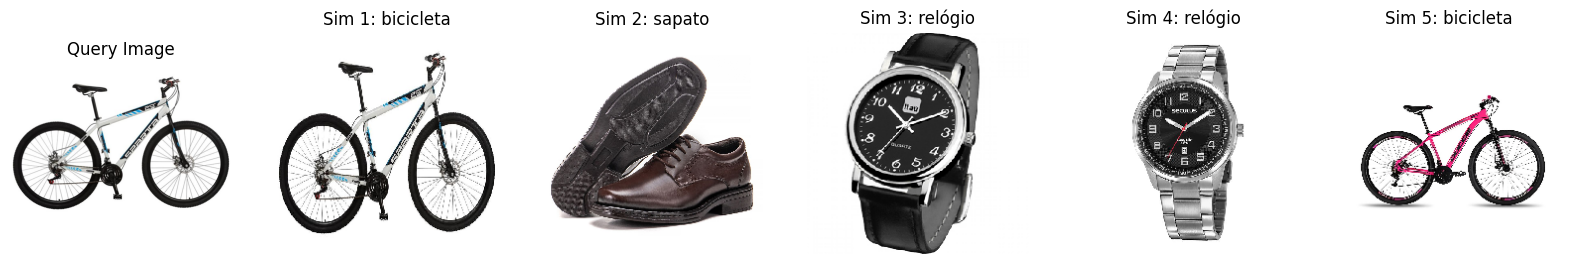

[('bicicleta',
  array([[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         ...,
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]],
  
         [[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.],
          ...,
          [1., 1., 1.],
          [1., 1., 1.],
          [1., 1.,

In [19]:
def recommend_similar_images(query_image_path, model, index, path_dict, top_n=5):
    # Carregar e pré-processar a imagem de consulta
    query_img = load_and_preprocess_image(query_image_path).squeeze(axis=0)

    # Extrair características da imagem de consulta
    query_features = extract_features(query_img, model).reshape(1, -1)

    # Procurar as imagens mais similares
    distances, indices = index.search(query_features, top_n)
    recommended_images = [path_dict[idx] for idx in indices[0]]

    # Exibir a imagem de consulta e as imagens recomendadas
    plt.figure(figsize=(20, 10))
    plt.subplot(1, top_n+1, 1)
    plt.imshow(load_img(query_image_path))
    plt.title('Query Image')
    plt.axis('off')

    for i, (cls, img) in enumerate(recommended_images):
        plt.subplot(1, top_n+1, i+2)
        plt.imshow(img)
        plt.title(f"Sim {i+1}: {cls}")
        plt.axis('off')

    plt.show()
    return recommended_images

# Exemplo de uso
query_image = '/content/sample_data/dataset/bicicleta/bicicleta.jpg'
recommend_similar_images(query_image, base_model, index, path_dict)